In [1]:
from __future__ import annotations
from typing import *
if TYPE_CHECKING:
    pass
from numpy.lib.function_base import iterable
from src.Kernel import GaussKernel
from src.EllipsoidRenderer import EllipsoidRenderer
from src.GridBuilder import ImageGridBuilder
from read_data import load_position_data
import numpy as np
import math
import matplotlib.pyplot as plt
import time

plt.gcf().set_dpi(200)

<Figure size 1200x800 with 0 Axes>

## Load Data

In [2]:
# Load Data

data = np.load('data/toastgitter/all_data.npy') # Shape [STEPS, NUM_REL]
p_pos, c_pos = load_position_data('data/toastgitter/LOGFILE_unified_coordinates.txt')
NUM_SAMPLES, NUM_RELATIONS = data.shape

print(data.shape)

(65536, 2013)


In [3]:
data.shape

(65536, 2013)

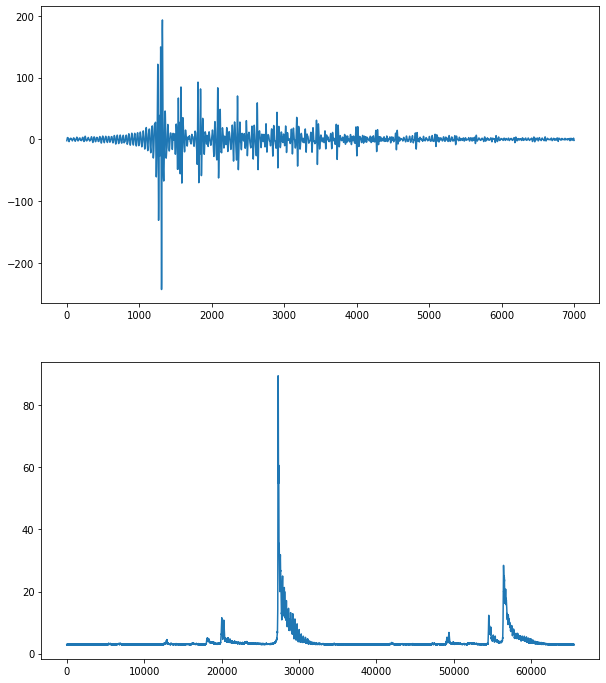

In [6]:
# Plot Data

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,12))
ax1.plot(data[26000:33000,0])
ax2.plot(np.std(data, axis=1))
plt.show()

## Setup Eperiment

In [5]:
# Setup experiment

from construct_matrix import MatrixBuilder
mb = MatrixBuilder(
    SPEED_OF_SOUND = 1_484_000.0, # [mm/s]
    SAMPLE_RATE = 100_000_000.0, # [1/s]
    ECHO_START_TIME = 0.0, # [s]

    data_path      = 'data/toastgitter/all_data.npy',
    positions_path = 'data/toastgitter/LOGFILE_unified_coordinates.txt',
    piezo_filter   = lambda pos: np.allclose(pos, np.array([385.0, -110.0, 198.0])),
    cMut_filter    = lambda pos: any(
        np.allclose(pos, np.array([k+311.1, -110.0, 198.0]))
        for k in range(0,61,4)
        for l in range(-5, 7, 5)

    ),
)

u = np.array([40,0,0], dtype=float)
v = np.array([0,0,-20], dtype=float)
o = np.array([320, -110, 10], dtype=float)

res_u = 40
res_v = 20

kernel = GaussKernel(5.0)

In [6]:
# Plot positions
mb.plot_positions(u=u, v=v, o=o, res_u=res_u, res_v=res_v, kernel=kernel)

In [7]:
# Construct matrix M

time_start = time.time()
M, lower_sample_idx, upper_sample_idx = mb.build_matrix(u=u, v=v, o=o, res_u=res_u, res_v=res_v, kernel=kernel)
time_stop = time.time()

print(time_stop-time_start)
print(lower_sample_idx, upper_sample_idx)
print(M.shape)

4.926156997680664
25448 29119
(58736, 800)


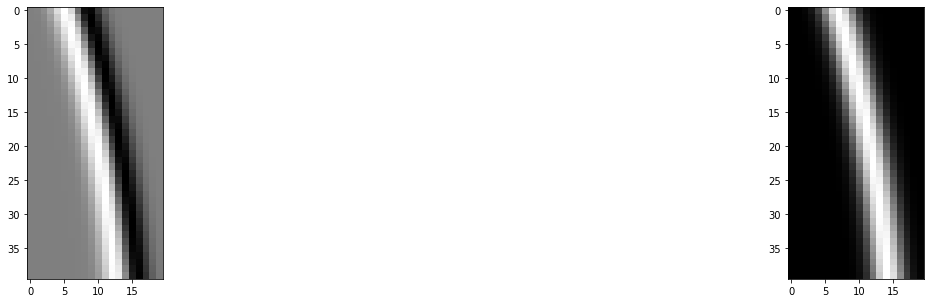

In [28]:
# Show example row vector of M
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))


fig = ax1.imshow(M.reshape([-1,res_u, res_v])[2000]-M.reshape([-1,res_u, res_v])[2020], cmap='gray')
fig = ax2.imshow(M.reshape([-1,res_u, res_v])[2020], cmap='gray')
# plt.colorbar()
plt.show()

# Do Calculations

In [9]:
# Compute Moore-Penrose-inverse
time_start = time.time()
Minv= np.linalg.pinv(M)
time_stop = time.time()

print(time_stop-time_start)

9.894581317901611


In [10]:
# Select necessary data and multiply with inverse matriv
selected_data = mb.data[lower_sample_idx:upper_sample_idx, mb.selected].flatten(order='F')

time_start = time.time()
x_hat = Minv @ selected_data
time_stop = time.time()
print(time_stop-time_start)

0.021051883697509766


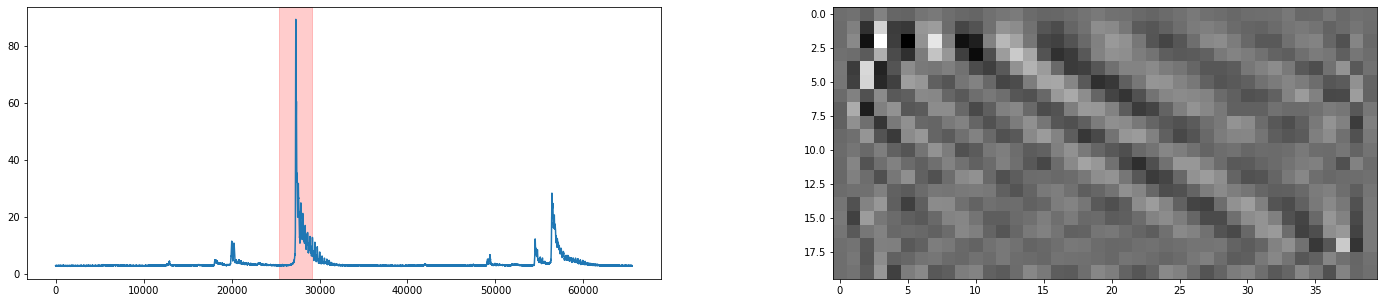

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))
ax1.plot(np.std(data, axis=1))
ax1.axvspan(lower_sample_idx, upper_sample_idx, color='red', alpha=0.2)
ax2.imshow(x_hat.reshape([res_u, res_v])[:,::-1].T, cmap='gray')

plt.show()

## Gradient Descent

In [29]:
# Compute Hessian and M^T @ y
H = M.T @ M
M_y = M.T @ selected_data

In [30]:
# Normalize
norm_coeff = np.linalg.norm(M_y)

H /= norm_coeff
M_y /= norm_coeff

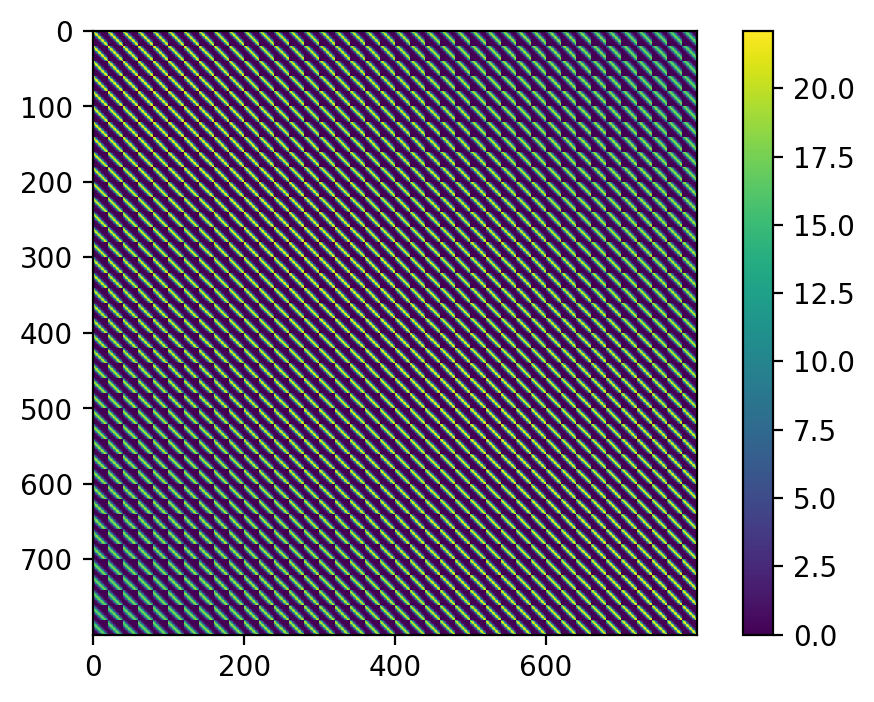

In [31]:
plt.gcf().set_dpi(200)
plt.imshow(H)
plt.colorbar()
plt.show()

In [32]:
# Do calculations
alpha_0 = 0.01
x_grad = M_y.copy()
momentum = np.zeros(x_grad.shape)

grad_norms = []
for it in range(5000):
    alpha = alpha_0 * np.power(it+1, -0.5)
    g = H@x_grad-M_y
    grad_norms.append(np.linalg.norm(g))
    x_grad -= alpha*(g+momentum)
    momentum = g

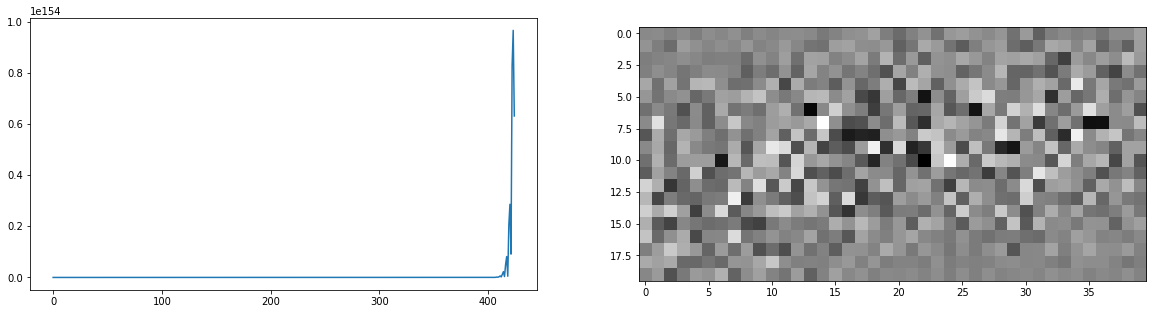

In [16]:
# Convergence plot & results

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(grad_norms)
ax2.imshow(x_grad.reshape([res_u, res_v])[:,::-1].T, cmap='gray')
plt.show()

In [17]:
# Compute determinant of H
np.linalg.det(H)

0.0

In [33]:
U, s, V = np.linalg.svd(H)

[5.00701871e+03 4.11737609e+03 3.01592988e+03 2.00763537e+03
 1.23997188e+03 7.21908828e+02 4.00467456e+02 2.12027045e+02
 1.50229397e+02 1.48884198e+02 1.10161725e+02 1.03572485e+02
 8.94954951e+01 5.81385039e+01 4.77968269e+01 4.22974140e+01
 2.14000789e+01 2.09426921e+01 1.71574098e+01 9.32600252e+00
 6.85217169e+00 4.08206939e+00 3.67878021e+00 3.49964469e+00
 3.18886378e+00 2.45299128e+00 2.18714570e+00 1.64998854e+00
 1.42343466e+00 1.09859179e+00 1.05301057e+00 6.07278263e-01
 5.24008250e-01 5.08263281e-01 3.90203711e-01 2.13197363e-01
 1.95331484e-01 1.36358209e-01 1.05018541e-01 8.19178679e-02
 6.18817641e-02 5.71833156e-02 5.47107553e-02 3.89215162e-02
 3.73131621e-02 3.37107222e-02 3.07109851e-02 2.17863380e-02
 1.99361017e-02 1.67651318e-02 1.59836867e-02 1.12223429e-02
 8.41460554e-03 6.75630650e-03 6.31997317e-03 5.18013771e-03
 3.49007364e-03 2.45521034e-03 2.29025211e-03 1.83301084e-03
 1.65436515e-03 9.49362882e-04 8.19478051e-04 6.96595185e-04
 6.20314730e-04 6.119461

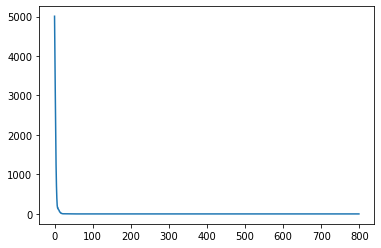

In [35]:
plt.plot(s)
print(s)

In [20]:
diff = x_hat - x_grad
print(np.linalg.norm(diff))

inf


In [21]:
print('Error of gradient descent method:', np.linalg.norm(M@x_grad-selected_data))
print('Error of moore-penrose method:', np.linalg.norm(M@x_hat-selected_data))

Error of gradient descent method: inf
Error of moore-penrose method: 4243.685115214455


## Null Space Analysis

In [22]:
# Is diff in nullspace of H
np.linalg.norm(H@diff)

inf

In [23]:
# Construct null space
from scipy.linalg import null_space
NSB = null_space(H*norm_coeff)
NSB.shape

(800, 659)

In [24]:
# Construct Nullspace Projection Matrix
NSP = NSB.T # np.linalg.inv(NSB.T@NSB)@NSB.T
NSP.shape

(659, 800)

In [25]:
# Compute 
Proj = np.identity(NSB.shape[0]) - NSB@NSP

x_grad_min = Proj @ x_grad 
print(np.linalg.norm(x_grad_min))
print(np.linalg.norm(x_hat))

inf
3955158829564.5835


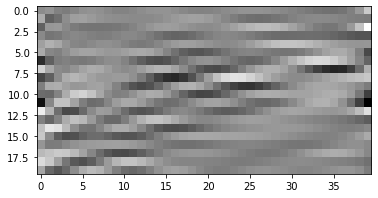

In [26]:
plt.imshow(x_grad_min.reshape([res_u, res_v])[:,::-1].T, cmap='gray')

## Sparsity Analysis

In [27]:
threshold = 1e-10
print('Sparsity of M', np.sum(M<threshold)/M.size)
print('Sparsity of M', np.sum(Minv<threshold)/Minv.size)

Sparsity of M 0.26063576852356307
Sparsity of M 0.49977090285344594


## Further steps
- plot data interval in date-mean / std plot
- use gpu via torch
- smear out ellips to reduce data dimensionality
- use numba and calculate matrix directly on gpu
- use matrix chunks to handle larger matricies